<a href="https://colab.research.google.com/github/VJ627/FML/blob/main/Vjammula_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 3-deep learning RNN

weather time series

Using data from a temperature forecast example

Gathering and unzipping data

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-22 22:37:36--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.161.144, 16.182.32.240, 54.231.134.232, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.161.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.3’

jena_climate_2009_2 100%[===================>]  12.94M  61.7MB/s    in 0.2s    

2023-11-22 22:37:37 (61.7 MB/s) - ‘jena_climate_2009_2016.csv.zip.3’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Read CSV file and print header, number of variables, and rows

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("No. of variables:", num_variables)
num_rows = len(lines)
print("No. of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
No. of variables: 15
No. of rows: 420451


Preprocess Jena climate CSV file for further processing using NumPy arrays

In [ ]:
import numpy as np

temperature = []
raw_data = []
for line in lines:
    values = [float(x) for x in line.split(",")[1:]]
    temperature.append(values[1])
    raw_data.append(values[:])

temperature = np.array(temperature)
raw_data = np.array(raw_data)

plotting temp vs data points

Text(0, 0.5, 'Temperature')

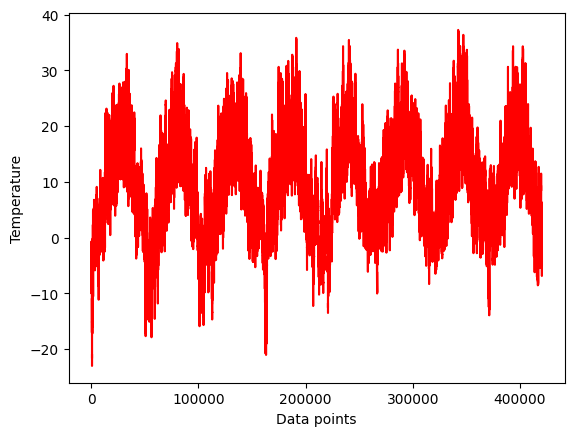

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature, color= 'red')
plt.xlabel('Data points')
plt.ylabel('Temperature')

Ploting the temperature time series for the first 10 days, we'll need to consider that each day has 144 data points, resulting in a total of 1,440 data points for these 10 days.

Text(0.5, 1.0, 'Temperature over the first 1440 time steps')

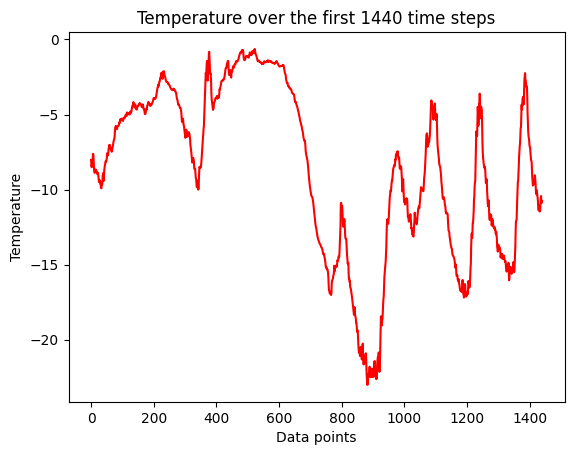

In [ ]:
plt.plot(range(1440), temperature[:1440] , color= 'red')
plt.xlabel('Data points')
plt.ylabel('Temperature')
plt.title("Temperature over the first 1440 time steps")

Data Splitting for Training, Validation, and Testing Sets

In [ ]:
training_samples = int(0.5 * len(raw_data))
validation_samples = int(0.25 * len(raw_data))
testing_samples = len(raw_data) - training_samples - validation_samples
print("training_samples:", training_samples)
print("validation_samples:", validation_samples)
print("testing_samples:", testing_samples)

training_samples: 210225
validation_samples: 105112
testing_samples: 105114


Normalization

In [ ]:
mean = raw_data[:training_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:training_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Creating tailored datasets for training, validation, and testing in a memoryefficient manner, this approach is to address the high redundancy within the dataset.

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

training_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=training_samples)

validation_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=training_samples,
    end_index=training_samples + validation_samples)

testing_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=training_samples + validation_samples)


In [ ]:
for samples, targets in training_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Using evaluate_naive_method to evaluate the perfomance,
The common-sense baseline approach to predict the temperature 24 hours ahead by assuming that it will be identical to the current temperature is a straightforward approach that can be used as a benchmark for comparison with other forecasting methods.

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(validation_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(testing_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


The validation MAE of 2.44 degrees Celsius and the test MAE of 2.62 degrees Celsius indicate that this approach has a moderate degree of accuracy. This is because the temperature does not usually change drastically from one day to the next, especially in the short term.

In [ ]:
!pip install tensorflow==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 36.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

Model -1 Dense Layer

Training and evaluation of the model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(training_dataset, epochs=10,
                    validation_data = validation_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 18s 21ms/step - loss: 12.8242 - mae: 2.7743 - val_loss: 12.1714 - val_mae: 2.7445
Epoch 2/10
819/819 [==============================] - 17s 20ms/step - loss: 9.2404 - mae: 2.3885 - val_loss: 10.1927 - val_mae: 2.5041
Epoch 3/10
819/819 [==============================] - 17s 21ms/step - loss: 8.3693 - mae: 2.2763 - val_loss: 10.2150 - val_mae: 2.5084
Epoch 4/10
819/819 [==============================] - 17s 20ms/step - loss: 7.8234 - mae: 2.2029 - val_loss: 13.5795 - val_mae: 2.8929
Epoch 5/10
819/819 [==============================] - 17s 20ms/step - loss: 7.5325 - mae: 2.1617 - val_loss: 10.3633 - val_mae: 2.5250
Epoch 6/10
819/819 [==============================] - 17s 20ms/step - loss: 7.2833 - mae: 2.1266 - val_loss: 10.7201 - val_mae: 2.5660
Epoch 7/10
819/819 [==============================] - 17s 20ms/step - loss: 7.0960 - mae: 2.0981 - val_loss: 10.5085 - val_mae: 2.5449
Epoch 8/10
819/819 [==============================] - 

In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

405/405 [==============================] - 5s 13ms/step - loss: 11.5766 - mae: 2.6834
Test MAE: 2.68


plotting training and validation

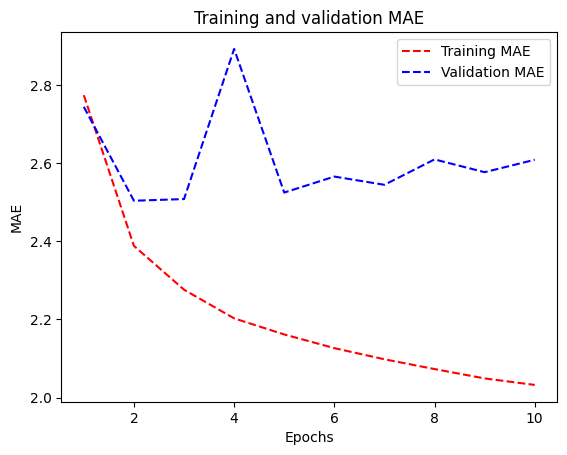

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="red", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Model 2 convolution

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 29s 34ms/step - loss: 22.8010 - mae: 3.7584 - val_loss: 15.2660 - val_mae: 3.0888
Epoch 2/10
819/819 [==============================] - 32s 39ms/step - loss: 15.5125 - mae: 3.1319 - val_loss: 14.6865 - val_mae: 3.0295
Epoch 3/10
819/819 [==============================] - 28s 34ms/step - loss: 13.9682 - mae: 2.9712 - val_loss: 16.4416 - val_mae: 3.2259
Epoch 4/10
819/819 [==============================] - 32s 39ms/step - loss: 13.1451 - mae: 2.8800 - val_loss: 17.7390 - val_mae: 3.3460
Epoch 5/10
819/819 [==============================] - 28s 34ms/step - loss: 12.5189 - mae: 2.8113 - val_loss: 16.3542 - val_mae: 3.1864
Epoch 6/10
819/819 [==============================] - 31s 38ms/step - loss: 11.9865 - mae: 2.7498 - val_loss: 16.8454 - val_mae: 3.2692
Epoch 7/10
819/819 [==============================] - 28s 34ms/step - loss: 11.5977 - mae: 2.7036 - val_loss: 14.5273 - val_mae: 2.9966
Epoch 8/10
819/819 [============================

plotting training and validation

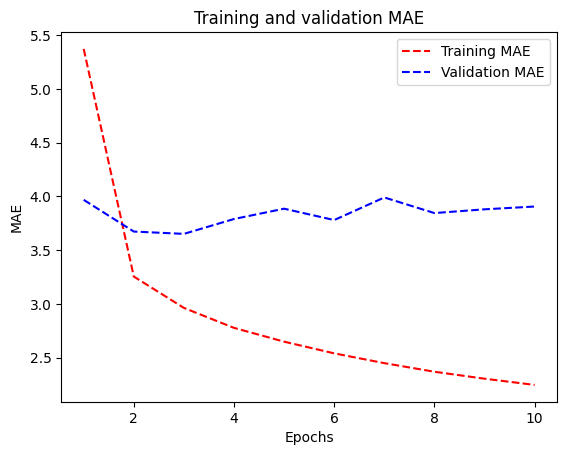

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="red", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

The performance of convolutional data models appears to be less effective when compared to conventional or dense models. This could be attributed to two main factors:

1. The assumption of translation invariance is not a strong fit for weather data. Weather conditions are often influenced by local and immediate factors, making the assumption less applicable.

2. The chronological order of the data is vital. Recent historical data tends to carry significantly more relevance for predicting the temperature of the following day in contrast to data from several days ago. Unfortunately, 1D convolutional neural networks are not adept at capturing this essential temporal order effectively.

RNN

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 28s 33ms/step - loss: 139.0098 - mae: 9.7240 - val_loss: 144.2017 - val_mae: 9.9243
Epoch 2/10
819/819 [==============================] - 27s 33ms/step - loss: 136.5559 - mae: 9.5789 - val_loss: 143.7739 - val_mae: 9.8821
Epoch 3/10
819/819 [==============================] - 27s 33ms/step - loss: 136.3294 - mae: 9.5555 - val_loss: 143.6521 - val_mae: 9.8637
Epoch 4/10
819/819 [==============================] - 27s 33ms/step - loss: 136.1866 - mae: 9.5387 - val_loss: 143.5310 - val_mae: 9.8460
Epoch 5/10
819/819 [==============================] - 31s 37ms/step - loss: 136.1432 - mae: 9.5353 - val_loss: 143.5672 - val_mae: 9.8522
Epoch 6/10
819/819 [==============================] - 27s 33ms/step - loss: 136.1139 - mae: 9.5326 - val_loss: 143.5248 - val_mae: 9.8474
Epoch 7/10
819/819 [==============================] - 27s 33ms/step - loss: 136.0895 - mae: 9.5300 - val_loss: 143.5359 - val_mae: 9.8496
Epoch 8/10
819/819 [==============

RNN- Stacking RNN layers

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 72s 84ms/step - loss: 136.8306 - mae: 9.5652 - val_loss: 143.4687 - val_mae: 9.8436
Epoch 2/10
819/819 [==============================] - 69s 84ms/step - loss: 135.9513 - mae: 9.5112 - val_loss: 143.4594 - val_mae: 9.8400
Epoch 3/10
819/819 [==============================] - 68s 83ms/step - loss: 135.9109 - mae: 9.5042 - val_loss: 143.4230 - val_mae: 9.8360
Epoch 4/10
819/819 [==============================] - 68s 83ms/step - loss: 135.9019 - mae: 9.5030 - val_loss: 143.4467 - val_mae: 9.8391
Epoch 5/10
819/819 [==============================] - 68s 83ms/step - loss: 135.8546 - mae: 9.4976 - val_loss: 143.4094 - val_mae: 9.8359
Epoch 6/10
819/819 [==============================] - 69s 84ms/step - loss: 135.8345 - mae: 9.4944 - val_loss: 143.4461 - val_mae: 9.8398
Epoch 7/10
819/819 [==============================] - 69s 84ms/step - loss: 135.8191 - mae: 9.4925 - val_loss: 143.4755 - val_mae: 9.8474
Epoch 8/10
819/819 [==============

GRU

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 58s 69ms/step - loss: 42.6858 - mae: 4.7633 - val_loss: 12.9874 - val_mae: 2.7238
Epoch 2/10
819/819 [==============================] - 57s 69ms/step - loss: 10.7201 - mae: 2.5462 - val_loss: 10.1469 - val_mae: 2.4653
Epoch 3/10
819/819 [==============================] - 58s 71ms/step - loss: 9.5705 - mae: 2.4189 - val_loss: 9.8535 - val_mae: 2.4176
Epoch 4/10
819/819 [==============================] - 58s 70ms/step - loss: 9.1991 - mae: 2.3730 - val_loss: 9.8730 - val_mae: 2.4166
Epoch 5/10
819/819 [==============================] - 55s 67ms/step - loss: 8.9760 - mae: 2.3416 - val_loss: 9.9789 - val_mae: 2.4238
Epoch 6/10
819/819 [==============================] - 56s 68ms/step - loss: 8.7949 - mae: 2.3163 - val_loss: 9.7616 - val_mae: 2.4078
Epoch 7/10
819/819 [==============================] - 56s 68ms/step - loss: 8.6225 - mae: 2.2926 - val_loss: 10.1723 - val_mae: 2.4447
Epoch 8/10
819/819 [==============================] - 56s

plotting training and validation

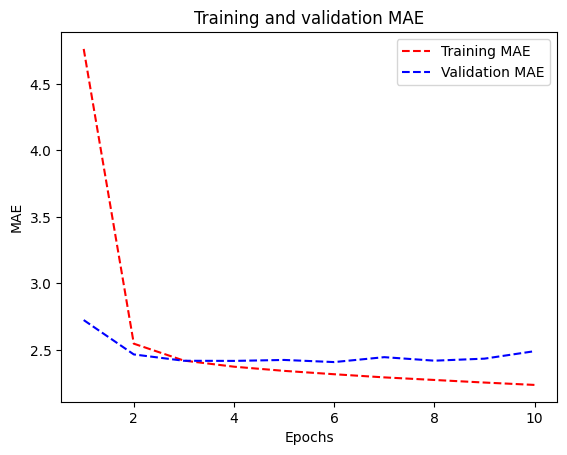

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="red", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 66s 78ms/step - loss: 43.9950 - mae: 4.8432 - val_loss: 13.0509 - val_mae: 2.7502
Epoch 2/10
819/819 [==============================] - 62s 76ms/step - loss: 11.3461 - mae: 2.6083 - val_loss: 9.6725 - val_mae: 2.4382
Epoch 3/10
819/819 [==============================] - 61s 74ms/step - loss: 9.7743 - mae: 2.4343 - val_loss: 9.6919 - val_mae: 2.4239
Epoch 4/10
819/819 [==============================] - 61s 75ms/step - loss: 9.3049 - mae: 2.3797 - val_loss: 10.4888 - val_mae: 2.4633
Epoch 5/10
819/819 [==============================] - 62s 75ms/step - loss: 9.0220 - mae: 2.3444 - val_loss: 10.6783 - val_mae: 2.4640
Epoch 6/10
819/819 [==============================] - 60s 74ms/step - loss: 8.8297 - mae: 2.3197 - val_loss: 10.6857 - val_mae: 2.4502
Epoch 7/10
819/819 [==============================] - 60s 73ms/step - loss: 8.6776 - mae: 2.2998 - val_loss: 10.5207 - val_mae: 2.4444
Epoch 8/10
819/819 [==============================] - 6

plotting training and validation

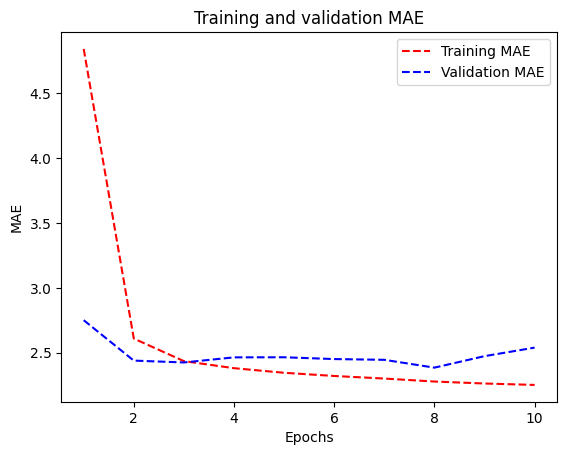

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="red", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM-Dropout

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 83s 98ms/step - loss: 44.7100 - mae: 4.9559 - val_loss: 12.4986 - val_mae: 2.6794
Epoch 2/10
819/819 [==============================] - 79s 97ms/step - loss: 19.8533 - mae: 3.4241 - val_loss: 9.7232 - val_mae: 2.4253
Epoch 3/10
819/819 [==============================] - 80s 98ms/step - loss: 18.2087 - mae: 3.2855 - val_loss: 9.3198 - val_mae: 2.3778
Epoch 4/10
819/819 [==============================] - 79s 96ms/step - loss: 17.3424 - mae: 3.2067 - val_loss: 9.4602 - val_mae: 2.3972
Epoch 5/10
819/819 [==============================] - 79s 96ms/step - loss: 16.9182 - mae: 3.1616 - val_loss: 9.2682 - val_mae: 2.3803
Epoch 6/10
819/819 [==============================] - 78s 95ms/step - loss: 16.4342 - mae: 3.1263 - val_loss: 9.3080 - val_mae: 2.3789
Epoch 7/10
819/819 [==============================] - 79s 97ms/step - loss: 16.1403 - mae: 3.0947 - val_loss: 9.1441 - val_mae: 2.3569
Epoch 8/10
819/819 [==============================] - 

plotting training and validation

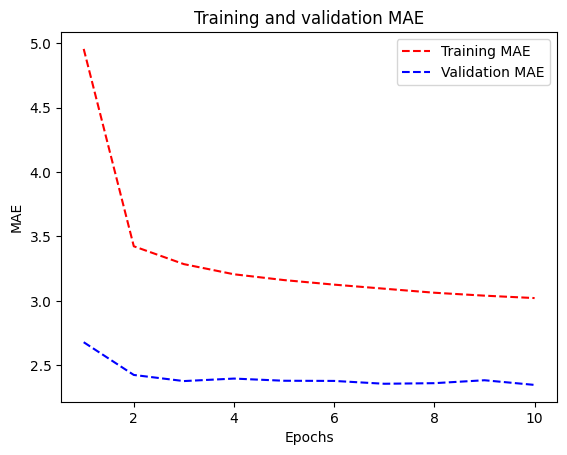

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="red", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM layers- 8 units

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 96s 113ms/step - loss: 71.4392 - mae: 6.4827 - val_loss: 37.3842 - val_mae: 4.5897
Epoch 2/10
819/819 [==============================] - 95s 116ms/step - loss: 22.1042 - mae: 3.4763 - val_loss: 13.1142 - val_mae: 2.6994
Epoch 3/10
819/819 [==============================] - 94s 115ms/step - loss: 11.4185 - mae: 2.6114 - val_loss: 10.2127 - val_mae: 2.4464
Epoch 4/10
819/819 [==============================] - 93s 114ms/step - loss: 10.0459 - mae: 2.4709 - val_loss: 10.3131 - val_mae: 2.4404
Epoch 5/10
819/819 [==============================] - 92s 113ms/step - loss: 9.7275 - mae: 2.4309 - val_loss: 9.5638 - val_mae: 2.4074
Epoch 6/10
819/819 [==============================] - 94s 115ms/step - loss: 9.5201 - mae: 2.4070 - val_loss: 9.5622 - val_mae: 2.3818
Epoch 7/10
819/819 [==============================] - 95s 116ms/step - loss: 9.4176 - mae: 2.3935 - val_loss: 9.6101 - val_mae: 2.3945
Epoch 8/10
819/819 [===========================

plotting training and validation

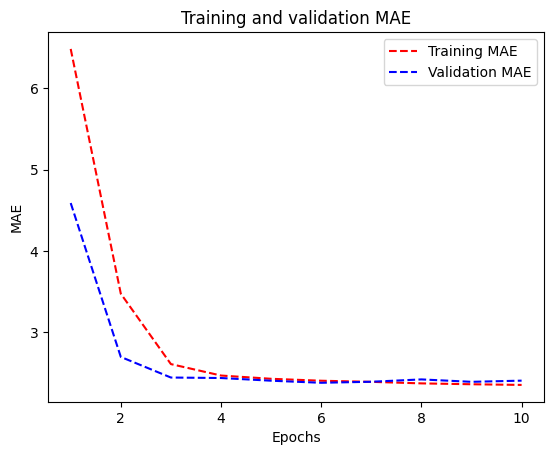

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="red", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM layers - 16 units

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 122s 145ms/step - loss: 36.8280 - mae: 4.3945 - val_loss: 11.8829 - val_mae: 2.6249
Epoch 2/10
819/819 [==============================] - 116s 141ms/step - loss: 10.0737 - mae: 2.4746 - val_loss: 9.9732 - val_mae: 2.4597
Epoch 3/10
819/819 [==============================] - 115s 141ms/step - loss: 8.6316 - mae: 2.3033 - val_loss: 10.1994 - val_mae: 2.4973
Epoch 4/10
819/819 [==============================] - 113s 137ms/step - loss: 7.9610 - mae: 2.2139 - val_loss: 10.5825 - val_mae: 2.5571
Epoch 5/10
819/819 [==============================] - 111s 135ms/step - loss: 7.5516 - mae: 2.1526 - val_loss: 10.6438 - val_mae: 2.5650
Epoch 6/10
819/819 [==============================] - 113s 138ms/step - loss: 7.1348 - mae: 2.0905 - val_loss: 10.8229 - val_mae: 2.5896
Epoch 7/10
819/819 [==============================] - 112s 136ms/step - loss: 6.8433 - mae: 2.0450 - val_loss: 11.1271 - val_mae: 2.6429
Epoch 8/10
819/819 [====================

plotting training and validation

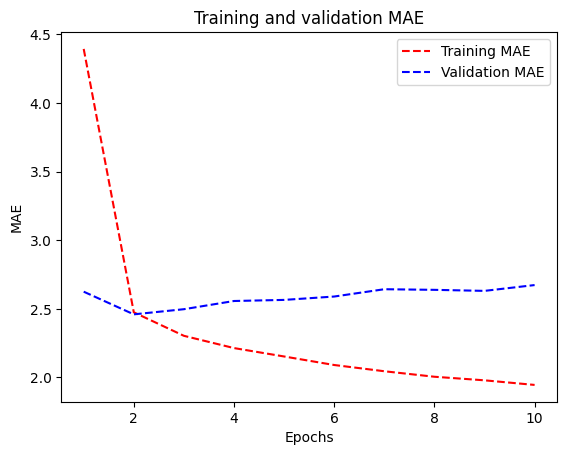

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="red", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM layers-32 units






In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 167s 199ms/step - loss: 23.4526 - mae: 3.4508 - val_loss: 10.3740 - val_mae: 2.5058
Epoch 2/10
819/819 [==============================] - 162s 198ms/step - loss: 8.0395 - mae: 2.2121 - val_loss: 10.7960 - val_mae: 2.5689
Epoch 3/10
819/819 [==============================] - 161s 196ms/step - loss: 6.2412 - mae: 1.9491 - val_loss: 11.1287 - val_mae: 2.6266
Epoch 4/10
819/819 [==============================] - 162s 197ms/step - loss: 5.1026 - mae: 1.7582 - val_loss: 13.0559 - val_mae: 2.8428
Epoch 5/10
819/819 [==============================] - 161s 196ms/step - loss: 4.2717 - mae: 1.6063 - val_loss: 13.5162 - val_mae: 2.9088
Epoch 6/10
819/819 [==============================] - 161s 196ms/step - loss: 3.6827 - mae: 1.4847 - val_loss: 13.6718 - val_mae: 2.8949
Epoch 7/10
819/819 [==============================] - 160s 196ms/step - loss: 3.1827 - mae: 1.3772 - val_loss: 14.2981 - val_mae: 2.9728
Epoch 8/10
819/819 [====================

plotting training and validation

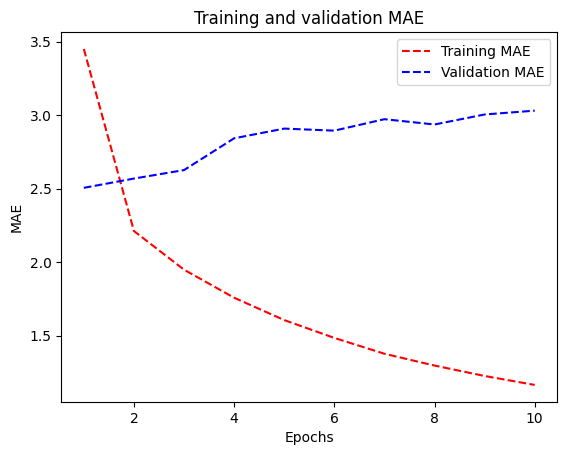

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="red", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM layers - 64 units

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 357s 431ms/step - loss: 12.8437 - mae: 2.6517 - val_loss: 9.7317 - val_mae: 2.4238
Epoch 2/10
819/819 [==============================] - 351s 428ms/step - loss: 5.2045 - mae: 1.7630 - val_loss: 12.6221 - val_mae: 2.8079
Epoch 3/10
819/819 [==============================] - 353s 430ms/step - loss: 3.2221 - mae: 1.3750 - val_loss: 12.2646 - val_mae: 2.7518
Epoch 4/10
819/819 [==============================] - 351s 429ms/step - loss: 2.2506 - mae: 1.1416 - val_loss: 13.0916 - val_mae: 2.8667
Epoch 5/10
819/819 [==============================] - 357s 436ms/step - loss: 1.6948 - mae: 0.9911 - val_loss: 12.7200 - val_mae: 2.8200
Epoch 6/10
819/819 [==============================] - 358s 436ms/step - loss: 1.3539 - mae: 0.8824 - val_loss: 13.4301 - val_mae: 2.8894
Epoch 7/10
819/819 [==============================] - 353s 431ms/step - loss: 1.1344 - mae: 0.8057 - val_loss: 12.9928 - val_mae: 2.8549
Epoch 8/10
819/819 [=====================

plotting training and validation

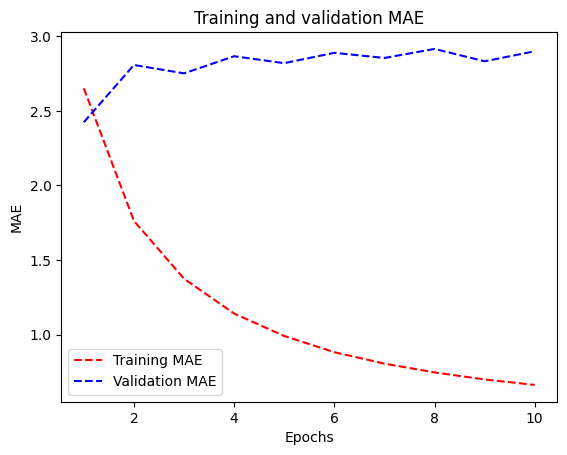

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="red", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM- dropout regularized

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 138s 162ms/step - loss: 70.0437 - mae: 6.3961 - val_loss: 32.2313 - val_mae: 4.1892
Epoch 2/10
819/819 [==============================] - 133s 162ms/step - loss: 30.7724 - mae: 4.1400 - val_loss: 13.8280 - val_mae: 2.7984
Epoch 3/10
819/819 [==============================] - 135s 164ms/step - loss: 24.0955 - mae: 3.7122 - val_loss: 10.6587 - val_mae: 2.4982
Epoch 4/10
819/819 [==============================] - 133s 163ms/step - loss: 22.3173 - mae: 3.5742 - val_loss: 10.3960 - val_mae: 2.4928
Epoch 5/10
819/819 [==============================] - 133s 163ms/step - loss: 21.0781 - mae: 3.4788 - val_loss: 10.3490 - val_mae: 2.4936
Epoch 6/10
819/819 [==============================] - 133s 162ms/step - loss: 20.1304 - mae: 3.4011 - val_loss: 9.7299 - val_mae: 2.4153
Epoch 7/10
819/819 [==============================] - 134s 163ms/step - loss: 19.1151 - mae: 3.3254 - val_loss: 9.8534 - val_mae: 2.4437
Epoch 8/10
819/819 [================

plotting training and validation

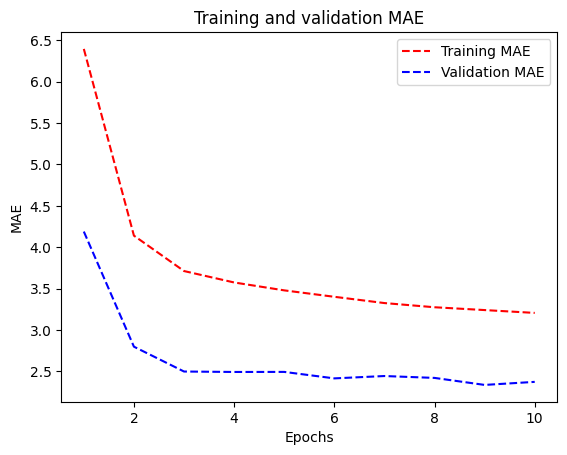

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="red", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM - Bidirectional

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 71s 83ms/step - loss: 24.8482 - mae: 3.5857 - val_loss: 10.7480 - val_mae: 2.5635
Epoch 2/10
819/819 [==============================] - 68s 82ms/step - loss: 9.5914 - mae: 2.4188 - val_loss: 9.5506 - val_mae: 2.3959
Epoch 3/10
819/819 [==============================] - 67s 82ms/step - loss: 8.6708 - mae: 2.2930 - val_loss: 10.0254 - val_mae: 2.4320
Epoch 4/10
819/819 [==============================] - 67s 82ms/step - loss: 8.1040 - mae: 2.2217 - val_loss: 10.2182 - val_mae: 2.4455
Epoch 5/10
819/819 [==============================] - 68s 83ms/step - loss: 7.6606 - mae: 2.1589 - val_loss: 10.8600 - val_mae: 2.5328
Epoch 6/10
819/819 [==============================] - 67s 82ms/step - loss: 7.3387 - mae: 2.1113 - val_loss: 10.4888 - val_mae: 2.4877
Epoch 7/10
819/819 [==============================] - 67s 81ms/step - loss: 7.0577 - mae: 2.0716 - val_loss: 11.0967 - val_mae: 2.5642
Epoch 8/10
819/819 [==============================] - 6

plotting training and validation

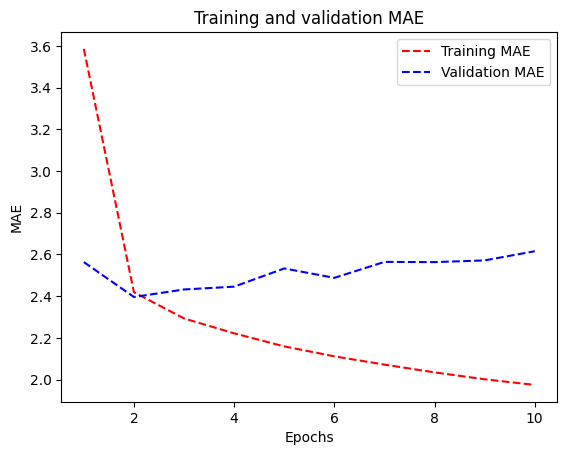

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="red", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM and Convolution

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(training_dataset, epochs=10, validation_data=validation_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(testing_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 43s 49ms/step - loss: 51.5690 - mae: 5.3720 - val_loss: 26.4806 - val_mae: 3.9681
Epoch 2/10
819/819 [==============================] - 37s 46ms/step - loss: 17.7820 - mae: 3.2545 - val_loss: 21.3641 - val_mae: 3.6730
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 14.6091 - mae: 2.9627 - val_loss: 20.9714 - val_mae: 3.6514
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 12.8809 - mae: 2.7770 - val_loss: 23.0654 - val_mae: 3.7897
Epoch 5/10
819/819 [==============================] - 38s 46ms/step - loss: 11.7393 - mae: 2.6486 - val_loss: 23.0674 - val_mae: 3.8858
Epoch 6/10
819/819 [==============================] - 37s 46ms/step - loss: 10.8429 - mae: 2.5399 - val_loss: 22.4515 - val_mae: 3.7799
Epoch 7/10
819/819 [==============================] - 37s 45ms/step - loss: 10.1138 - mae: 2.4488 - val_loss: 24.1085 - val_mae: 3.9902
Epoch 8/10
819/819 [============================

plotting training and validation

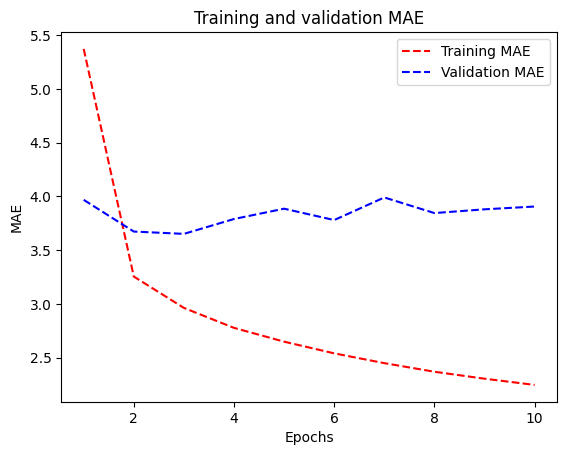

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="red", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

MAE evaluation

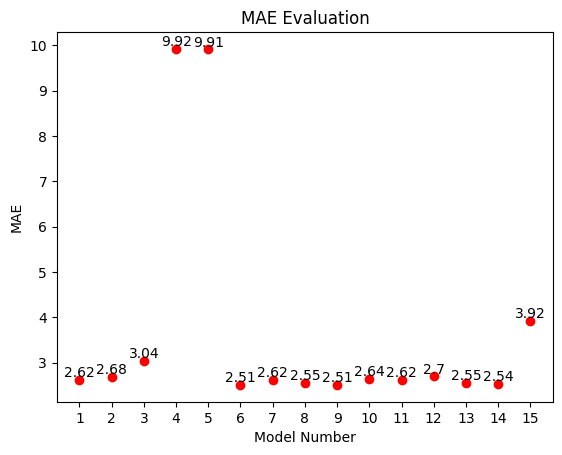

In [ ]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14","15")
Mae = (2.62,2.68,3.04,9.92,9.91,2.51,2.62,2.55,2.51,2.64,2.62,2.70,2.55,2.54,3.92)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()